In [62]:
import matplotlib.pyplot as plt
import os

In [24]:
import idx2numpy
import numpy as np

Xtr = idx2numpy.convert_from_file('mnist/train-images.idx3-ubyte')
Ytr = idx2numpy.convert_from_file('mnist/train-labels.idx1-ubyte')
Xtst = idx2numpy.convert_from_file('mnist/t10k-images.idx3-ubyte')
Ytst = idx2numpy.convert_from_file('mnist/t10k-labels.idx1-ubyte')

In [8]:
#creating 7x12 bitmapped images to train LeNet against
from bitstring import BitArray

def bitstring_to_pbm(bitstring_data, width, height, filename):
    """
    Converts a bitstring to a PBM image file.

    Args:
        bitstring_data: A bitstring object containing the image data.
        width: The width of the image in pixels.
        height: The height of the image in pixels.
        filename: The name of the PBM file to create.
    """
    if len(bitstring_data) != width * height:
        raise ValueError("Bitstring length does not match image dimensions.")

    with open(filename, 'w') as f:
        f.write("P1\n")  # PBM format header (ASCII)
        f.write(f"{width} {height}\n")  # Image dimensions

        # Write pixel data (1 for black, 0 for white)
        for i in range(height):
            for j in range(width):
                f.write(str(int(bitstring_data[i * width + j])) + " ")
            f.write("\n")

In [786]:
#need ascii 32 to 126
filename='ASCII_pbms/ASCII_126.pbm'
data = '''
0000000
0000000
0000000
0000000
0000000
0001001
0110110
0000000
0000000
0000000
0000000
0000000
'''

width = 7
height = 12
image_data = np.array(list(data.replace('\n', ''))).reshape(height, width).astype(np.int8)

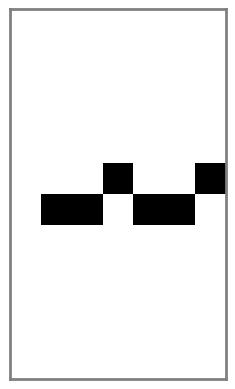

In [787]:
# Display the image using imshow
plt.imshow(image_data, cmap='gray_r')
ax = plt.gca()

# Set border properties
for spine in ax.spines.values():
    spine.set_edgecolor('grey')  # Set border color
    spine.set_linewidth(2)      # Set border thickness

# Remove the ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [788]:
#save image

data = BitArray(bin=data)

#check for file
if filename.split('/')[1] not in os.listdir('ASCII_pbms'):
    print('creating file', filename)
    bitstring_to_pbm(data, width, height, filename)
else:
    print('file already exists')

creating file ASCII_pbms/ASCII_126.pbm


In [789]:
#print PBM images
def read_pbm_file(filename):
    with open(filename, 'r') as f:
        l = f.readlines()
    bits = []
    for i in range(2, len(l)):
        lstr = l[i].replace('\n', '').replace(' ', '')
        bits.append([int(b) for b in lstr])

    bits = np.array(bits)
    return bits

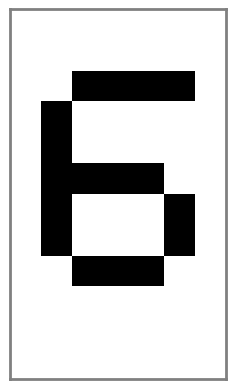

In [811]:
filename = 'ASCII_pbms/ASCII_54.pbm'
image_data = read_pbm(filename)

# Display the image using imshow
plt.imshow(image_data, cmap='gray_r')
ax = plt.gca()

# Set border properties
for spine in ax.spines.values():
    spine.set_edgecolor('grey')  # Set border color
    spine.set_linewidth(2)      # Set border thickness

# Remove the ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [34]:

#creation of handwritten text dataset
import pandas as pd

splits = {'train': 'data/train.parquet', 'validation': 'data/validation.parquet', 'test': 'data/test.parquet'}
df_train = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["test"])

#define types
df_train['type'] = 'train'
df_val['type'] = 'validation'
df_test['type'] = 'test'


#concat, isolate image bytestrings, save
df = pd.concat([df_train, df_val, df_test])
df['bytes'] = df.image.apply(lambda x: x['bytes'])
df[['text', 'bytes', 'type']].to_parquet('df.parquet.gzip', compression='gzip') 

In [35]:
df

,text,image,type,bytes
0,put down a resolution on the subject,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,and he is to be backed by Mr. Will,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,nominating any more Labour life Peers,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,M Ps tomorrow. Mr. Michael Foot has,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"Griffiths, M P for Manchester Exchange .",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...
2910,"just dusty-grey but muddy , slimy even .",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2911,"the fake friend of the family , like the",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2912,"client's eyes , the dust of fake security , of",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2913,"the result being somehow as ineffective , not",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
